In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import stats

def simulate_lorenz_distributions(num_samples, param_distributions, initial_distributions, 
                                   times,
                                   solver_method='LSODA', atol=1e-6, rtol=1e-6):
    """
    Simulates the Lorenz system for multiple samples with varying parameters 
    and initial conditions.

    Parameters
    ----------
    num_samples : int
        Number of samples to generate.
    param_distributions : dict
        Dictionary with keys 'sigma', 'rho', 'beta', each a scipy.stats 
        distribution object.
    initial_distributions : dict
        Dictionary with keys 'x0', 'y0', 'z0', each a scipy.stats distribution 
        object.
    times : array, 
        Simulation times to be sampled and returned.
    solver_method : str, optional
        ODE solver method to use. Default is 'LSODA'.
    atol : float, optional
        Absolute tolerance for the ODE solver. Default is 1e-6.
    rtol : float, optional
        Relative tolerance for the ODE solver. Default is 1e-6.

    Returns
    -------
    dict
        Dictionary with keys 0, ..., len(times), each containing a numpy
        array of shape (num_samples, 3) with the system's state (x, y, z) at 
        the respective times. Also contains the samples drawn from the 
        distributions in param_distributions and initial_distributions.
    """
    max_time = times[-1]
    # Prepare results storage
    results = {
        'sigma': [],
        'rho': [],
        'beta': [],
        'x0': [],
        'y0': [],
        'z0': []
    }
    for ii in range(len(times)):
        results[ii] = []
    for _ in range(num_samples):
        # Sample parameters
        sigma = np.abs(param_distributions['sigma'].rvs())
        rho = np.abs(param_distributions['rho'].rvs())
        beta = np.abs(param_distributions['beta'].rvs())
        
        # Sample initial conditions
        x0 = initial_distributions['x0'].rvs()
        y0 = initial_distributions['y0'].rvs()
        z0 = initial_distributions['z0'].rvs()
        initial_state = np.array([x0, y0, z0])
        
        # Define the Lorenz system equations
        def lorenz_system(t, state):
            x, y, z = state
            dxdt = sigma * (y - x)
            dydt = x * (rho - z) - y
            dzdt = x * y - beta * z
            return [dxdt, dydt, dzdt]
        
        # Solve the ODE
        sol = solve_ivp(lorenz_system, [0, max_time], initial_state, 
                        method=solver_method, t_eval=times,
                        atol=atol, rtol=rtol)
        
        if sol.success:
            # Extract states at the time points
            states = sol.y.T  # Transpose to get shape (n_time_points, 3)
            for ii in range(len(times)):
                results[ii].append(states[ii])
            # save sample
            results['sigma'].append(sigma)
            results['rho'].append(rho)
            results['beta'].append(beta)
            results['x0'].append(x0)
            results['y0'].append(y0)
            results['z0'].append(z0)
        else:
            # If integration fails, append NaNs
            for ii in range(len(times)):
                results[ii].append(np.array([np.nan, np.nan, np.nan]))
            # save sample
            results['sigma'].append(sigma)
            results['rho'].append(rho)
            results['beta'].append(beta)
            results['x0'].append(x0)
            results['y0'].append(y0)
            results['z0'].append(z0)
    
    # Convert lists to numpy arrays
    for key in results:
        results[key] = np.array(results[key])
    
    return results

In [2]:
param_dists = {
    'sigma':stats.uniform(loc=10, scale=0),
    'rho': stats.uniform(loc=28, scale=0),
    'beta': stats.uniform(loc=8/3, scale=0)}
# param_dists = {
#     'sigma':stats.norm(loc=10, scale=10/100),
#     'rho': stats.norm(loc=28, scale=28/100),
#     'beta': stats.norm(loc=8/3, scale=3/800)}
init_dists = {
    'x0':stats.norm(loc=0, scale=1.5),
    'y0': stats.norm(loc=0, scale=1.5),
    'z0': stats.norm(loc=20, scale=1)}

In [ ]:
times = np.array([0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0])
results = simulate_lorenz_distributions(
    100_000, param_dists, init_dists,
    times=times
    )

In [4]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

In [11]:
def plot_lower_triangle(samples, var_names, n_samples=None, num_dims=None,
                        title=None):
    """Plot lower triangle with histograms and scatter plots"""
    data = samples[:n_samples, :num_dims]
    
    
    g = sns.PairGrid(pd.DataFrame(data, columns=var_names), diag_sharey=False)
    g.map_lower(sns.scatterplot, alpha=0.3, s=10)
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.histplot, kde=False, stat="density")
    if title is None:
        title ="Pairwise Relationships for Lorenz system"
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


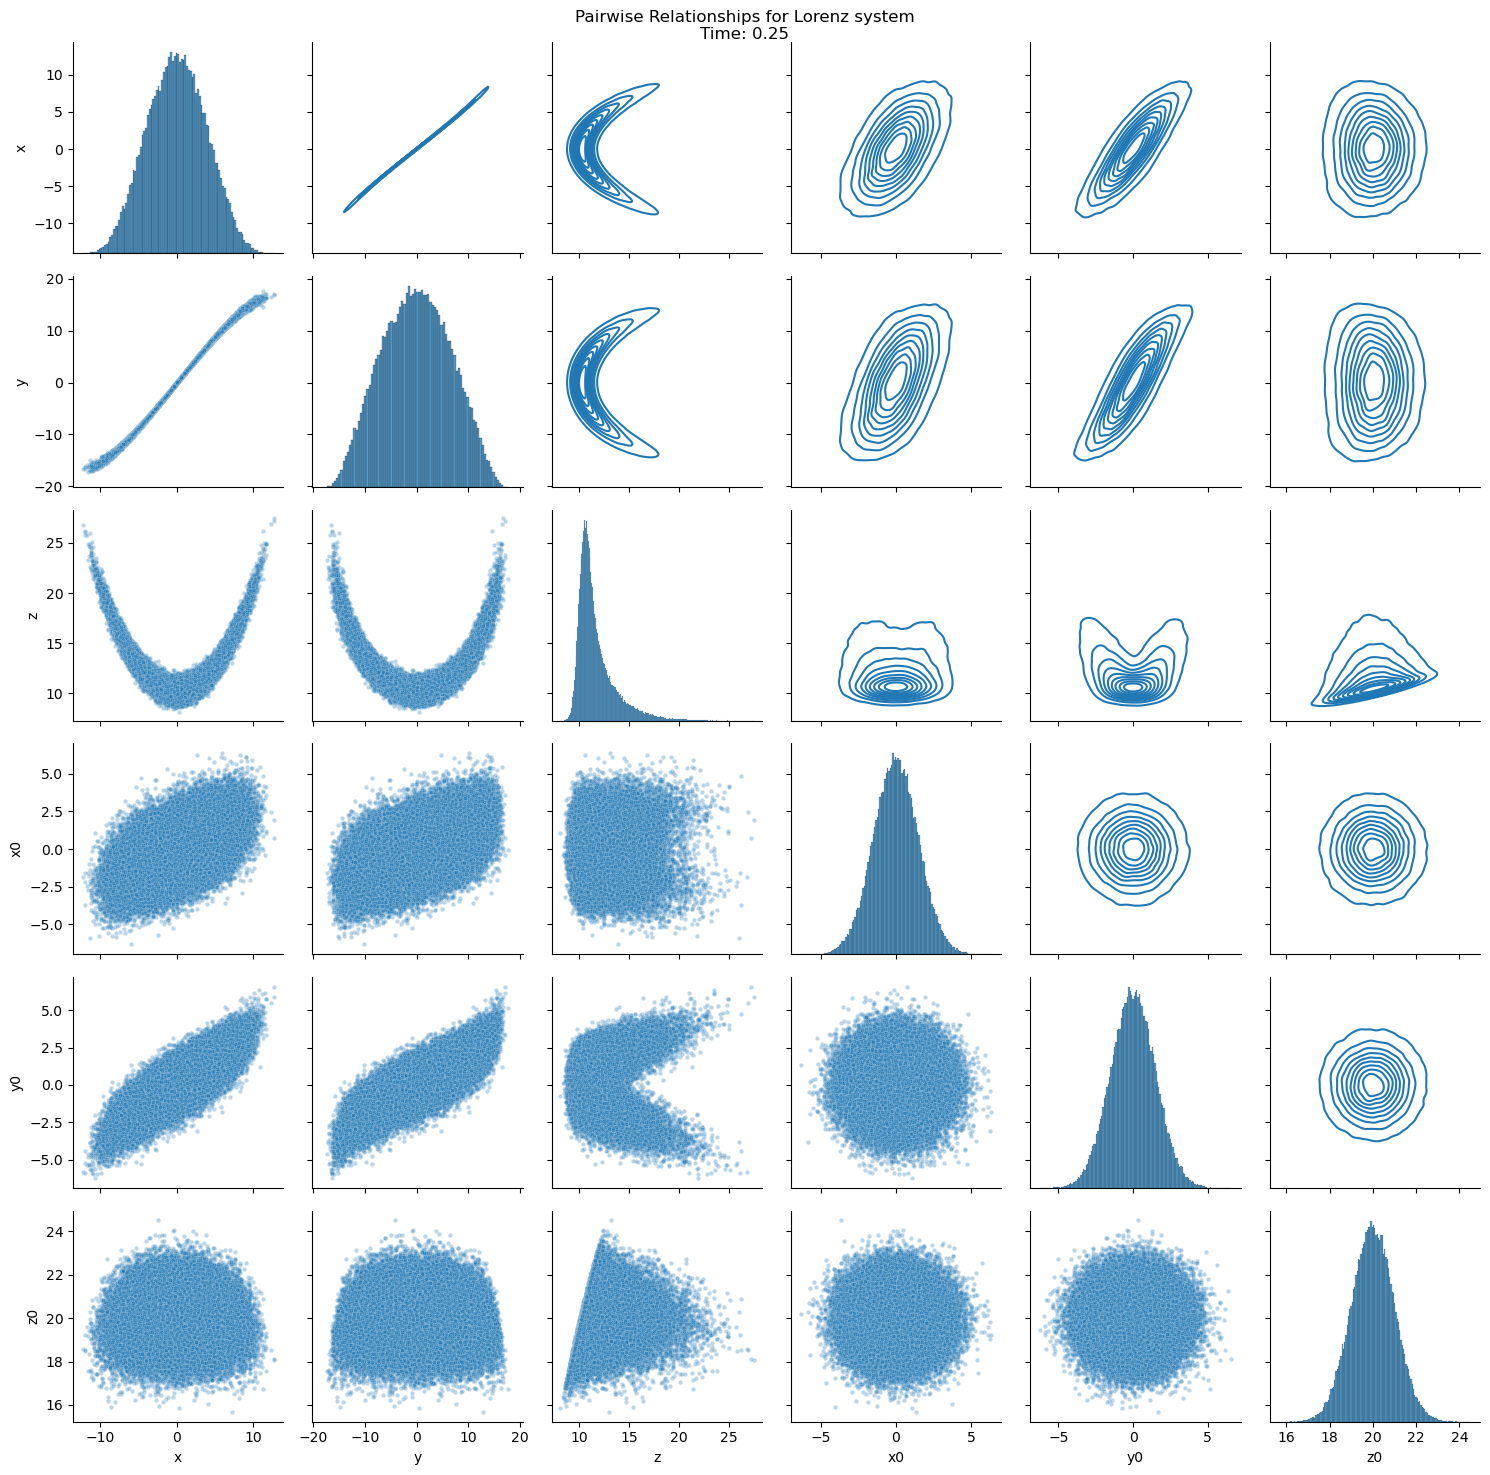

In [ ]:
for ii in range(5):
    samples = np.concatenate([results[ii],
                            results['x0'].reshape(-1, 1), 
                            results['y0'].reshape(-1, 1), 
                            results['z0'].reshape(-1, 1)],axis=1)
    var_names = [f'x', 'y', 'z', 'x0', 'y0', 'z0']
    plot_lower_triangle(
        samples, var_names,
        title=f'Pairwise Relationships for Lorenz system\nTime: {times[ii]}')